Get the original image from google drive. This movie was already stabilized in iMovie. This removed the high frequency shaking, but left the slow drift motion. This notebook detects the sun in every frame, shifts each frame such that the sun is always in the same position, and writes the motion-corrected frames to disk, and finally stitches them together into a movie.

There are a lot of ways to accomplish this task. This algorithm is very simple -- matching a sun template -- but not very flexible. An alternative is to directly match consecutive frames, i.e., [register the images](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.register_translation).

In [1]:
### Get the data

import os
import requests


# Download original movie file
src_filename = 'eclipse.mp4'
if not os.path.exists(src_filename):
    !wget "https://docs.google.com/uc?export=download&id=0B-ayIMQgiR1dUGx3MEVFRzVxYzQ" -O $src_filename
else:
    print ('Source movie file already downloaded.')

# Prepare temporary output directory
output_frame_dir = 'out_frames'    
if not os.path.exists(output_frame_dir):
    os.makedirs(output_frame_dir)


--2017-09-05 23:13:23--  https://docs.google.com/uc?export=download&id=0B-ayIMQgiR1dUGx3MEVFRzVxYzQ
Resolving docs.google.com (docs.google.com)... 216.58.216.78, 2607:f8b0:4009:815::200e
Connecting to docs.google.com (docs.google.com)|216.58.216.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/at5sk39redbjbucqmlt8ist6eb5tv574/1504670400000/00185222986835148555/*/0B-ayIMQgiR1dUGx3MEVFRzVxYzQ?e=download [following]
--2017-09-05 23:13:25--  https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/at5sk39redbjbucqmlt8ist6eb5tv574/1504670400000/00185222986835148555/*/0B-ayIMQgiR1dUGx3MEVFRzVxYzQ?e=download
Resolving doc-10-60-docs.googleusercontent.com (doc-10-60-docs.googleusercontent.com)... 172.217.8.161, 2607:f8b0:4009:80a::2001
Connecting to doc-10-60-docs.googleusercontent.com (doc-10-60-docs.googleusercontent.com)|

In [2]:
import numpy as np
import skvideo.io

videodata = skvideo.io.vread(src_filename)
gray_frames = videodata.sum(axis=-1)
print(videodata.shape, gray_frames.shape)


/home/brian/miniconda3/envs/video/lib/python3.6/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


(423, 720, 1280, 3) (423, 720, 1280)


In [3]:
### Register each frame to a reference frame

from skimage.feature import register_translation

shifts, errs = [], []
ref_frame = gray_frames[200]
for frame_num, frame in enumerate(gray_frames):
    if frame_num % 50 == 0:
        print('Frame %i of %i' % (frame_num, len(videodata)))
    shift, err, _ = register_translation(ref_frame, frame)
    shifts.append(shift)
    errs.append(err)
shifts = np.round(np.array(shifts)).astype(int)


Frame 0 of 423
Frame 50 of 423
Frame 100 of 423
Frame 150 of 423
Frame 200 of 423
Frame 250 of 423
Frame 300 of 423
Frame 350 of 423
Frame 400 of 423


Note that with a frame/template of this size, naive convolution is too slow, and `fftconvolve` is necessary. It would be much more efficient to FFT the template only once, compute the spatial FFT of the video data, and then just multiply them. This is fast enough for a demo!

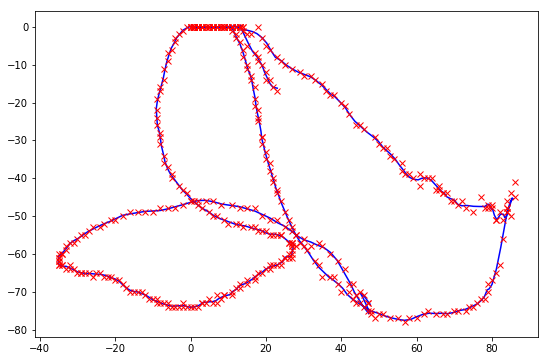

In [4]:
### Smooth an plot the "trajectory" of the sun

from math import factorial
import matplotlib.pyplot as plt
%matplotlib inline

# from here: http://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


t = np.arange(len(shifts))
win_size = 11
degree = 5
row_shifts_smooth = savitzky_golay(shifts[:,0], win_size, degree)
col_shifts_smooth = savitzky_golay(shifts[:,1], win_size, degree)
shifts_smooth = np.vstack([row_shifts_smooth, col_shifts_smooth]).T

plt.figure(figsize=(9,6))
plt.plot(shifts_smooth[:,1], shifts_smooth[:,0], 'b-')
plt.plot(shifts[:,1], shifts[:,0], 'rx')

In [5]:
import numpy as np
from skimage.util import crop

crop_size = int(round(np.abs(shifts).max()))
shifts_smooth = np.round(shifts_smooth).astype(int)

for frame_num, (frame, shift) in enumerate(zip(videodata, shifts_smooth)):
    if frame_num % 50 == 0:
        print('Frame %i of %i' % (frame_num, len(videodata)))
        
    # Shift the frame
    shifted_frame = np.roll(frame, shift=(shift[0], shift[1], 0), axis=(0,1,2))
    
    # Zero-fill the wrapped values
    out_frame = shifted_frame.copy()
    if shift[0] != 0:
        if shift[0] > 0:
            out_frame[:shift[0]] = 0
        else:
            out_frame[shift[0]:] = 0
    if shift[1] != 0:
        if shift[1] > 0:
            out_frame[:, :shift[1]] = 0
        else:
            out_frame[:, shift[1]:] = 0
        
    # Save motion-compensated frame
    out_fn = os.path.join(output_frame_dir, 'frame%03d.png' % frame_num)
    plt.imsave(out_fn, out_frame)
    

Frame 0 of 423
Frame 50 of 423
Frame 100 of 423
Frame 150 of 423
Frame 200 of 423
Frame 250 of 423
Frame 300 of 423
Frame 350 of 423
Frame 400 of 423


In [6]:
### Convert frames to a mp4 movie

!ffmpeg -r 30 -i $output_frame_dir/frame%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p eclipse_corrected.mp4

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

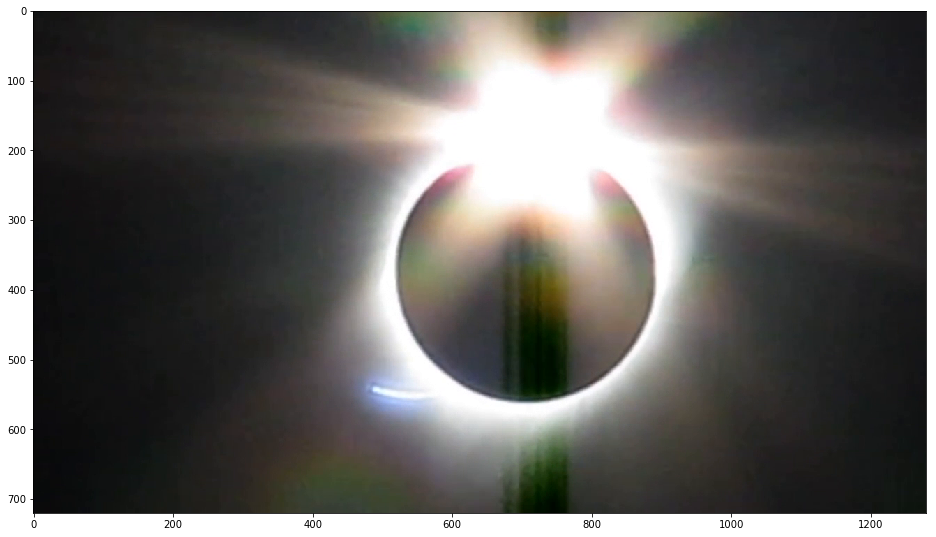

In [7]:
ring_frame = videodata[130]

plt.figure(figsize=(16,10))
plt.imshow(ring_frame)
plt.imsave('diamond_ring.jpg', ring_frame)